In [1]:
# producing a report from sierra
# INN-Reach -> Reports -> (report type) In transit too long
#
# ... output data looks like this:
# Min. Days In Transit    : 1
# Patron Number           : p11111111
# Patron Name             : Joe, Patron, J
# Virtual Item Number     : i1111111@some_code
# Barcode                 : some_barcode
# Home Library            : some-home-library
# Item Location           : item-external-location
# Title                   : Some Title
# Call Number             : Some Callnumber
# In Transit Date         : Thu Apr 02 2020
# Central Name            : ohpir
# Central Status          : some status

In [2]:
import pandas as pd
import re
from sqlalchemy import create_engine
import altair as alt
from IPython.display import HTML, Image

In [3]:
record_list = []
with open('long-in-transit-2022-02-01.txt', 'r') as f:
    header = f.readline()
    count = 0
    record = {}
    while line := f.readline():
        count += 1
        # print(line, end='')
        row = line.split(':')
        if len(row) == 1:
            record_list.append(record)
            record = {}
        else:
            record[row[0].strip()] = row[1].strip()

In [4]:
df = pd.DataFrame(record_list)
# convert dates from this format: 'Thu Apr 02 2020'
# ... to this format:             '2020-04-02 00:00:00'
df['in_transit_date'] =  pd.to_datetime(df['In Transit Date'])

In [5]:
engine = create_engine('sqlite:///ill-in-transit.db')
df.to_sql(name = 'data', con=engine, if_exists='replace')

sql = """\
with search as (
    SELECT
    rowid,
    cast(julianday('now') as INTEGER) - cast(julianday(data.in_transit_date) as INTEGER) as days_in_transit
    FROM
    data
)
SELECT
count(*) as total_in_transit,
(
    SELECT
    count(*)
    FROM
    search
    WHERE
    search.days_in_transit > 10
) as count_over_10_days,
round(avg(search.days_in_transit), 2) as avg_days_in_transit
FROM
search
"""
pd.read_sql(sql=sql, con=engine)

,total_in_transit,count_over_10_days,avg_days_in_transit
0,2291,734,10.08


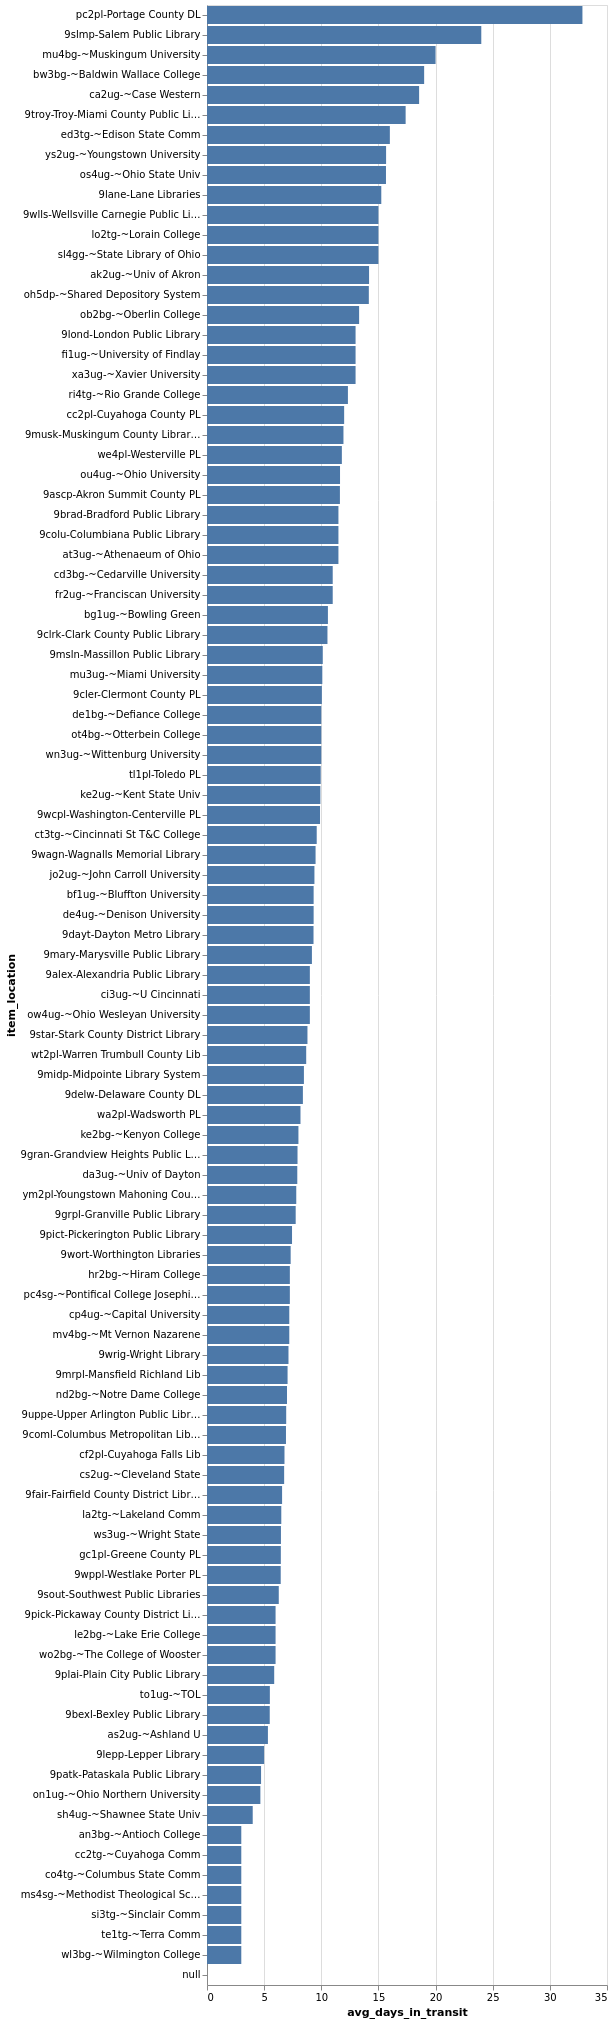

In [6]:
sql = """\
with search as (
    SELECT
    rowid,
    cast(julianday('now') as INTEGER) - cast(julianday(data.in_transit_date) as INTEGER) as days_in_transit,
    "Item Location" as item_location
    FROM
    data
)
SELECT
item_location,
round(avg(days_in_transit), 2) as avg_days_in_transit,
count(*) as count_items
FROM
search
group by 1
"""

df = pd.read_sql(sql=sql, con=engine)
# df.head()

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('avg_days_in_transit', ),
    y=alt.Y('item_location', sort='-x'),
    tooltip=['item_location', 'avg_days_in_transit', 'count_items'],
    # color='op_name',
).properties(
    title=''
).configure_title(
    # fontSize=20,
    anchor='start',
)

# chart.save('output.html')
# HTML('output.html')

# saved the vis as png, to display in github as an example ...
Image('visualization.png')